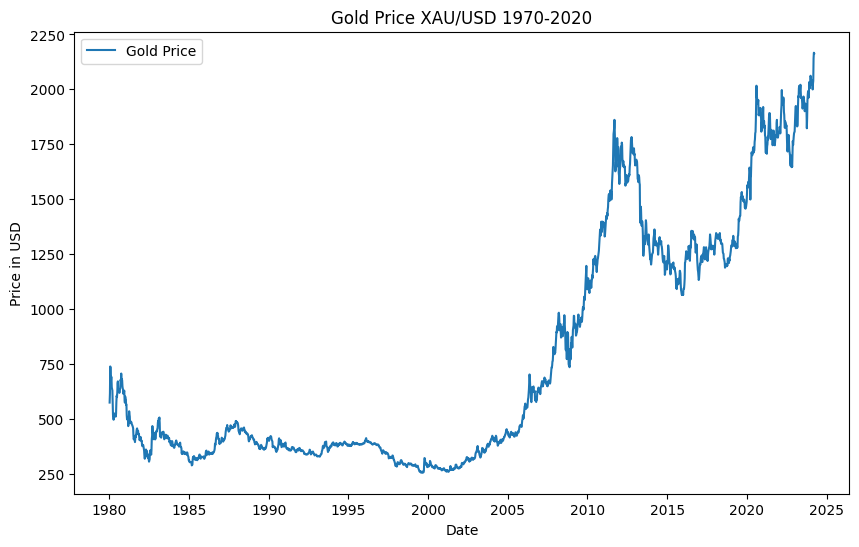

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

price_path = "./data/gold/Prices.csv"
goldPrice = pd.read_csv(price_path)

goldPrice = goldPrice[['Date', 'USD']]
goldPrice['Date'] = pd.to_datetime(goldPrice['Date'])
goldPrice.set_index('Date', inplace=True)
goldPrice = goldPrice[goldPrice.index >= '1980-01-01']

goldPrice['USD'] = pd.to_numeric(goldPrice['USD'].replace(',', '', regex=True), errors='coerce')

goldPrice_weekly = goldPrice['USD'].resample('W').mean()
goldPrice_weekly

plt.figure(figsize=(10,6))
plt.plot(goldPrice_weekly.index, goldPrice_weekly, label='Gold Price')

# k_wave_starts = ['1930', '1980', '2030']
# for year in k_wave_starts:
#     plt.axvline(pd.to_datetime(year), color='r', linestyle='--')

plt.title('Gold Price XAU/USD 1970-2020')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

In [1]:
CPI_path = "./data/macro/CPI.csv"
GDP_path = "./data/macro/GDP.csv"
DXY_path = "./data/macro/DXY.csv"
CPI = pd.read_csv(CPI_path)
GDP = pd.read_csv(GDP_path)
DXY = pd.read_csv(DXY_path)
CPI['Date'] = pd.to_datetime(CPI['Date'])
GDP['Date'] = pd.to_datetime(GDP['Date'])
DXY['Date'] = pd.to_datetime(DXY['Date'])
CPI.set_index('Date', inplace=True)
GDP.set_index('Date', inplace=True)
DXY.set_index('Date', inplace=True)
CPI = CPI[CPI.index >= '1980-01-01']
GDP = GDP[GDP.index >= '1980-01-01']
DXY = DXY[DXY.index >= '1980-01-01']

plt.figure(figsize=(10,6))
plt.plot(CPI.index, CPI, label='CPI')
plt.plot(GDP.index, GDP['GDP'], label='GDP')
plt.plot(DXY.index, DXY['Close'], label='DXY')
plt.title('CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

NameError: name 'pd' is not defined